# 1. Retrieving CAPE data

The first half of this notebook walks through the process of scraping data on COGS courses from the CAPE website. Later, this process will be abstracted to iterate through and scrape data for each of the other departments.

### 1a. Import the packages we need to retrieve the dataset

**urllib** is used to create an appropriately formatted request for retrieving the targeted data.  
**BeautifulSoup** is then used to extract table data from the retrieved HTML.

In [1]:
from urllib.parse import urlencode
from urllib.request import build_opener
from bs4 import BeautifulSoup

### 1b. Define some variables to control the scope of our data request

1. **name** - If provided, must be in format "Last_Name, First_Name (Middle_Name)"
2. **course** - If provided, must be in in format "DEPT xxx"
    1. Not providing a course number returns data for all courses in the department.
    2. Entering "COGS 1" also returns data for COGS 11, 14A, 14B, 100, etc. There is no known way around this.
3. **base** and **errors** are fixed values and should not be modified

The values given below will request all data from COGS classes, regardless of the teaching professor.

In [2]:
name = ""
course = "COGS"

# To be suffixed by $name and $course
base = "http://cape.ucsd.edu/responses/Results.aspx?"
# Common error messages returned by CAPE
errors = [ \
    "No CAPEs have been submitted that match your search criteria.",
    "Please enter your search criteria"
]

### 1c. Authenticate to UCSD SSO

In [3]:
import requests
import getpass

In [ ]:
# Setup: Create a session with persistent cookies
s = requests.Session()
s.headers.update({'User-agent': 'Mozilla/5.0'})

# 1. Make an initial request that redirects to SSO
# - Stores cookies 'sto-id', 'JSESSIONID' into session
r = s.get(link)
# print(s.cookies.items())

# 2. Post authentication to SSO portal
# - Stores cookie 'shib_idb_session' into session
# - Returned HTML contains two hidden inputs, 'RelayState', 'SAMLResponse'
print('[ Enter login information ]')
r2 = s.post(r.url,
            data = {
                'urn:mace:ucsd.edu:sso:username': input('Username: '),
                'urn:mace:ucsd.edu:sso:password': getpass.getpass(),
                '_eventId_proceed': ''
            })
# print(s.cookies.items())

# 3. Extract the two hidden inputs, post to SAML2
# - Sets cookie '_shib_session_...', '_saml_idp_...'
soup = BeautifulSoup(r2.text)
saml_data = { key: soup.find('input', attrs={"name": key}).attrs['value'] for key in ['RelayState', 'SAMLResponse'] }

r3 = s.post('http://cape.ucsd.edu/Shibboleth.sso/SAML2/POST', data=saml_data)
# print(s.cookies.items())

s.close()

# 4. Done! Call s.get(url) to retrieve protected resources.

### 1d. Query CAPE for course data
Create the appropriate URL from input values above and feed response HTML into BeautifulSoup

In [ ]:
# Formatted query link
link = base + urlencode(list(zip(["Name", "CourseNumber"], [name, course])))

soup = BeautifulSoup(s.get(link).text, "lxml")
print("Retrieved HTML from", link)

# 2. Transform the response HTML into a pandas DataFrame

**Note:** This code was written before I discovered the read_html method of the **pandas** library, which already implements much of the following logic.

`pd.read_html(str(soup), flavor='bs4')`

In [ ]:
import pandas as pd

# Retrieve each of the table's rows
selector = lambda classes: 'odd' in classes or 'even' in classes
classes = soup.tr.find_all_next("tr", class_=selector)

# Extract column names
header = [ col.string.lower() for col in soup.tr.contents if col.name == "th" and col.has_attr('scope') ]

results = []
# Extract column values from each of the retrieved rows
for line in classes:
    values = filter(lambda col: col.name == "td", line.contents)
    values = [ v.text.strip() for v in values ]
    results.append(values)

df = pd.DataFrame(results, columns=header)

# 3. Tidying the extracted dataset

So far, so good.  
Let's take a look at our data!

In [ ]:
df.info()
df.describe(include=['object'])

In [ ]:
df.head()

All the key information is here but could definitely use some cleaning up.

### 3a. Standardizing null values

We need to replace the "N/A" values which are strings, not actual NaN values (note: panda's read_html function allows specifying 'na_values').  
We will also drop any rows for which there were no evaluations made. ( `df[df["evals made"] == 0]` )

In [ ]:
import numpy as np

for key in df.keys():
    df[key].replace("N/A", np.nan, inplace=True)

no_evals = df["evals made"] == "0"
print("Dropping", len(df[no_evals]), "rows with 0 CAPE evaluations")

df = df[~no_evals].reset_index(drop=True)

In [ ]:
df.info()

### 3b. Tidying up data entries and transforming data formats

The data formats for columns **course**, **avg grade expected**, **avg grade received** need to be reformatted as tidy data.

In [ ]:
import re

# Extracting course number - "COGS 102A - Distributed Cognition (A)" becomes "COGS 102A"
course = re.compile("([A-Z]+ [0-9]+[A-Z]?)")
df["course"] = df["course"].str.extract(course, expand=False)

# All values under "term" are in format XXYY, where XX refers to the term and YY refers to the year
# Change values to follow format YYX s.t. YYX is a single value (we want FA15 to be greater than SP13)
quarters = { "FA": 0., "WI": 2.5, "SP": 5., "S1": 7.5, "S2": 7.5, "S3": 7.5, "SU": 7.5 }
df["term"] = df["term"].apply(lambda term: (10 * float(term[2:])) + quarters[term[:2]])

# Convert to numeric type
for key in ["enroll", "evals made", "study hrs/wk"]:
    df[key] = pd.to_numeric(df[key])

# Strip off percentage signs and convert to numeric type
rcmnd_filter = lambda x: x if pd.isnull(x) else float(x.rstrip(" %"))
df["rcmnd class"] = df["rcmnd class"].apply(rcmnd_filter)
df["rcmnd instr"] = df["rcmnd instr"].apply(rcmnd_filter)

# Strip off letter grade and convert to numeric type
grades = re.compile("[A-Z][-+]? \((.*)\)")
grade_filter = lambda x: x if pd.isnull(x) else float(grades.match(x).groups()[0])
df["avg grade expected"] = df["avg grade expected"].apply(grade_filter)
df["avg grade received"] = df["avg grade received"].apply(grade_filter)

df.head()

# 4. Code condensation
Much better! Now let's review by starting over and compiling all of this code into a few "simple" functions.

# Note: Enter 'y' in the dialog below to reset the environment

In [ ]:
%reset

In [1]:
from bs4 import BeautifulSoup
from urllib.parse import urlencode
import requests, getpass
import pandas as pd
import numpy as np
import re

def login():
    # Setup: Create a session with persistent cookies
    s = requests.Session()
    s.headers.update({'User-agent': 'Mozilla/5.0'})

    # 1. Make an initial request that redirects to SSO
    r = s.get('http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=COGS 108')

    # 2. Post authentication to SSO portal
    print('[ Enter login information ]')
    r2 = s.post(r.url,
                data = {
                    'urn:mace:ucsd.edu:sso:username': input('Username: '),
                    'urn:mace:ucsd.edu:sso:password': getpass.getpass(),
                    '_eventId_proceed': ''
                })

    # 3. Extract the two hidden inputs, post to SAML2
    soup = BeautifulSoup(r2.text)
    saml_data = { key: soup.find('input', attrs={"name": key}).attrs['value'] for key in ['RelayState', 'SAMLResponse'] }
    r3 = s.post('http://cape.ucsd.edu/Shibboleth.sso/SAML2/POST', data=saml_data)

    return s

def get_website(link):
    print("Retrieving HTML from", link)
    return BeautifulSoup(s.get(link).text, "lxml")

errors = [ \
    "No CAPEs have been submitted that match your search criteria.",
    "Please enter your search criteria"
]
base = "http://cape.ucsd.edu/responses/Results.aspx?"

def get_cape(params):
    # urlencode maps None as "None"
    params = map(lambda d: d if d else '', params)
    data = urlencode(dict(zip(["Name", "CourseNumber"], params)))

    # Validate whether CAPE data is available
    soup = get_website(base + data)
    for e in errors:
        if e in str(soup.tr.contents):
            print("Error occurred in retrieving HTML from", base + data)
            return None

    return soup

def parse_cape(soup):
    # Retrieve each of the table's rows
    selector = lambda classes: 'odd' in classes or 'even' in classes
    classes = soup.tr.find_all_next("tr", class_=selector)

    # Extract column names
    header = [ col.string.lower() for col in soup.tr.contents if col.name == "th" and col.has_attr('scope') ]

    results = []
    # Extract column values from each of the retrieved rows
    for line in classes:
        values = filter(lambda col: col.name == "td", line.contents)
        values = [ v.text.strip() for v in values ]
        results.append(values)

    ###############################################
    
    df = pd.DataFrame(results, columns=header)

    for key in df.keys():
        df[key].replace("N/A", np.nan, inplace=True)

    no_evals = df["evals made"] == "0"
    print("Dropping", len(df[no_evals]), "rows with 0 CAPE evaluations")

    df = df[~no_evals].reset_index(drop=True)

    # Extracting course number - "COGS 102A - Distributed Cognition (A)" becomes "COGS 102A"
    course = re.compile("([A-Z]+ [0-9]+[A-Z]?)")
    df["course"] = df["course"].str.extract(course, expand=False)

    # All values under "term" are in format XXYY, where XX refers to the term and YY refers to the year
    # Change values to follow format YYX s.t. YYX is a single value (we want FA15 to be greater than SP13)
    quarters = { "FA": 0., "WI": 2.5, "SP": 5., "S1": 7.5, "S2": 7.5, "S3": 7.5, "SU": 7.5 }
    df["term"] = df["term"].apply(lambda term: (10 * float(term[2:])) + quarters[term[:2]])

    # Convert to numeric type
    for key in ["enroll", "evals made", "study hrs/wk"]:
        df[key] = pd.to_numeric(df[key])

    # Strip off percentage signs and convert to numeric type
    rcmnd_filter = lambda x: x if pd.isnull(x) else float(x.rstrip(" %"))
    df["rcmnd class"] = df["rcmnd class"].apply(rcmnd_filter)
    df["rcmnd instr"] = df["rcmnd instr"].apply(rcmnd_filter)

    # Strip off letter grade and convert to numeric type
    grades = re.compile("[A-Z][-+]? \((.*)\)")
    grade_filter = lambda x: x if pd.isnull(x) else float(grades.match(x).groups()[0])
    df["avg grade expected"] = df["avg grade expected"].apply(grade_filter)
    df["avg grade received"] = df["avg grade received"].apply(grade_filter)

    return df

In [2]:
# Requires entry of UCSD authentication credentials
s = login()

[ Enter login information ]
Username: jey025
········


# 5. Extract CAPE data for all departments

Now that the web scraping code is separated into functions, let's retrieve all the data the CAPE has to offer.

### 5a. Retrieve a list of all department codes

Why not?

In [3]:
soup = get_website("https://blink.ucsd.edu/instructors/courses/schedule-of-classes/subject-codes.html")
df = pd.read_html(str(soup), flavor='bs4')[0]

# Credits: https://stackoverflow.com/a/26147330
df.columns = df.iloc[0]
df.reindex(df.index.drop(0))

codes = df["Code"].tolist()[1:]
print("Department Codes:", ', '.join(codes))

Retrieving HTML from https://blink.ucsd.edu/instructors/courses/schedule-of-classes/subject-codes.html
Department Codes: AAS, AESE, AIP, ANAR, ANBI, ANES, ANSC, ANTH, AUD, AWP, BENG, BGGN, BGJC, BGRD, BGSE, BIBC, BICD, BIEB, BILD, BIMM, BIOM, BIPN, BISP, BNFO, CAT, CCS, CENG, CGS, CHEM, CHIN, CLAS, CLIN, CLRE, CLSS, CMM, COGR, COGS, COMM, CONT, CSE, DDPM, DERM, DOC, DSC, DSE, DSGN, EAP, ECE, ECON, EDS, EMED, ENG, ENVR, ERC, ESYS, ETHN, ETIM, EXPR, FILM, FMPH, FPM, GLBH, GMST, GPCO, GPEC, GPGN, GPIM, GPLA, GPPA, GPPS, HDP, HDS, HIAF, HIEA, HIEU, HIGR, HILA, HILD, HINE, HISC, HITO, HIUS, HLAW, HMNR, HUM, ICAM, ICEP, INTL, IRGN, IRLA, JAPN, JUDA, JWSP, LATI, LAWS, LHCO, LIAB, LIDS, LIEO, LIFR, LIGM, LIGN, LIHI, LIHL, LIIT, LIPO, LISL, LISP, LTAF, LTAM, LTCH, LTCO, LTCS, LTEA, LTEN, LTEU, LTFR, LTGK, LTGM, LTHE, LTIT, LTKO, LTLA, LTPR, LTRU, LTSP, LTTH, LTWL, LTWR, MAE, MATH, MATS, MBC, MCWP, MDE, MED, MGT, MGTA, MGTF, MGTP, MMW, MSED, MSP, MUIR, MUS, NANO, NEU, NEUG, OPTH, ORTH, PATH, PED

### 5b. Extract CAPE data for each department subject (saves files to disk!)

Most of the code below is simply a framework to automatically parse every department subject code.  

For any given department subject code, this code can be boiled down into the following lines:

    code = "COGS"
    filename = "COGS.json"
    
    open(filename, "w").write(parse_cape(get_soup(("", code))).to_json())

In [4]:
from time import sleep
import os.path

# These department subject codes were pre-identified as not having any CAPE data.
# We will automatically ignore these subject codes in order to save time.
# If you want to see the code at work, then uncomment the triple quotes just above and below.
null_codes = ['AESE', 'ANES', 'AUD', 'BGGN', 'BGJC', 'BGRD', 'BGSE', \
              'BIOM', 'BNFO', 'CCS', 'CLIN', 'CLRE', 'CLSS', 'CMM', \
              'COGR', 'DDPM', 'DERM', 'DSE', 'EAP', 'EMED', 'ETIM', \
              'EXPR', 'GMST', 'GPCO', 'GPEC', 'GPGN', 'GPIM', 'GPLA', \
              'GPPA', 'GPPS', 'HDS', 'HIGR', 'HLAW', 'ICEP', 'IRGN', \
              'IRLA', 'JWSP', 'LHCO', 'LIDS', 'LIEO', 'LIHI', 'LTCO', \
              'LTHE', 'LTPR', 'MATS', 'MBC', 'MDE', 'MED', 'MGTA', \
              'MGTF', 'MGTP', 'MSED', 'MSP', 'NEU', 'NEUG', 'OPTH', \
              'ORTH', 'PATH', 'PEDS', 'PHAR', 'RAD', 'RMAS', 'RMED', \
              'SIOB', 'SIOC', 'SIOG', 'SOCG', 'SOMC', 'SOMI', 'SPPS', \
              'SURG', 'TDGR', 'UROL', 'WES']
codes = [ c for c in codes if not c in null_codes ]

success = []
failures = []
skipped = []

for code in codes:
    # Skip department code if the file "code.json" already exists (no need to overwrite)
    filename = code + ".json"
    if os.path.isfile(filename):
        skipped.append(code)
        continue
    
    soup = get_cape(("", code))
    # soup will be None if there is an error in parsing the website or if CAPE returns no data
    if not soup:
        failures.append(code)
    else:
        open(filename, "w").write(parse_cape(soup).to_json())
        success.append(code)
    
    # Introducing artifical delay so we don't spam requests (not really necessary b/c parsing time)
    sleep(np.random.uniform(0.75, 1))

print("* Successfully retrieved CAPE data for", len(success), "department subject codes")
print(', '.join(success), '\n')
print("* Failed to retrieve CAPE data for", len(failures), "department subject codes")
print(', '.join(failures), '\n')
print("* Skipped the following department subject codes (already exists)")
print(', '.join(skipped))

Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=AAS
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=AIP
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=ANAR
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=ANBI
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=ANSC
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=ANTH
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=AWP
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=BENG
Dropping 0 

Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=LIIT
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=LIPO
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=LISL
Error occurred in retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=LISL
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=LISP
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=LTAF
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=LTAM
Dropping 0 rows with 0 CAPE evaluations
Retrieving HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=LTCH
Dropping 0 rows with 0 CAPE ev

### 5c. Use data from the top 10 department subjects with the most CAPE data (by filesize)

In [5]:
import pandas as pd

In [6]:
import os

data_files = filter(lambda f: '.json' in f, os.listdir('.'))

# Collect file statistics from each file (we are interested primarily in filesize)
data_files = [ (f, os.stat(f).st_size) for f in data_files ]
data_files.sort(key = lambda x: x[1], reverse=True)
data_files = [ f[0] for f in data_files[:10] ]

cape_data = [ pd.read_json(open(f).read()).sort_index() for f in data_files ]

print(', '.join(data_files))
data_files = [ f.rstrip('.json') for f in data_files ]

SE.json, MATH.json, CSE.json, ECON.json, CHEM.json, POLI.json, PSY.json, PSYC.json, ENG.json, PHYS.json


# 6. Finally, time to crunch some numbers!

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import pprint
pp = pprint.PrettyPrinter(indent=4)

### 6a. Let's take a look at the standard summary statistics.

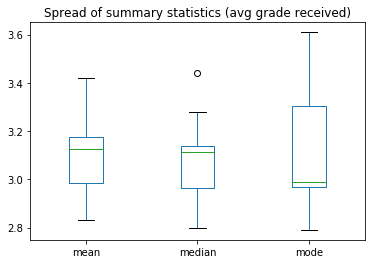

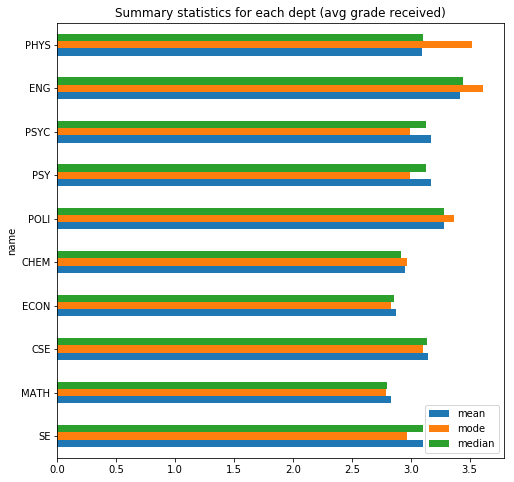

In [8]:
summary_stats = pd.DataFrame( \
         { 'name' : code,
           'mean' : cape["avg grade received"].mean(),
           'mode' : cape["avg grade received"].mode()[0],
           'median' : cape["avg grade received"].median()
         } for code, cape in zip(data_files, cape_data)
    )

summary_stats.plot(title='Spread of summary statistics (avg grade received)', kind='box')
summary_stats.plot(title='Summary statistics for each dept (avg grade received)',
                   kind='barh', x = 'name', y = ['mean', 'mode', 'median'], figsize=(8, 8))

### 6b. Can we find any correlations between pairs of variables for any of the departments?

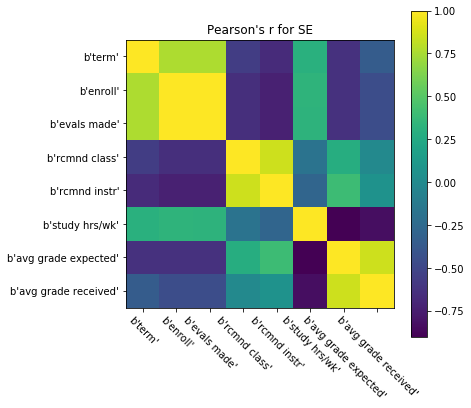

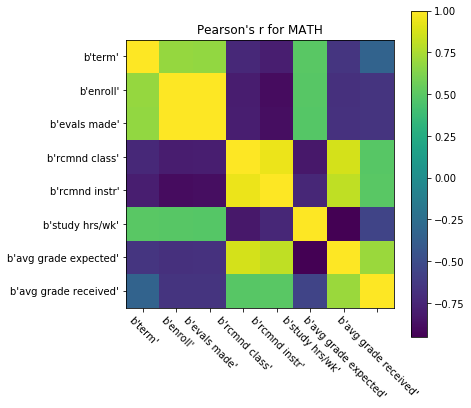

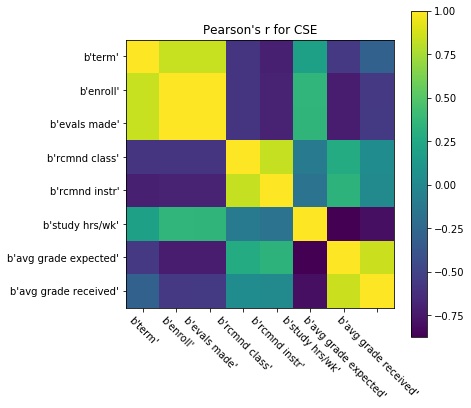

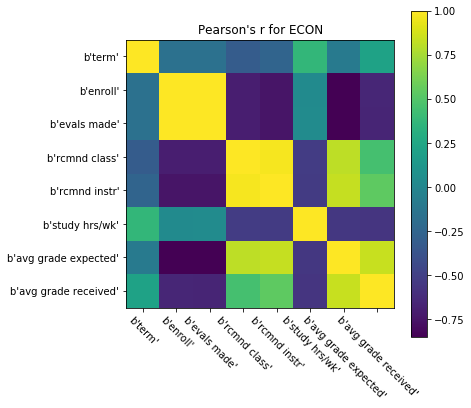

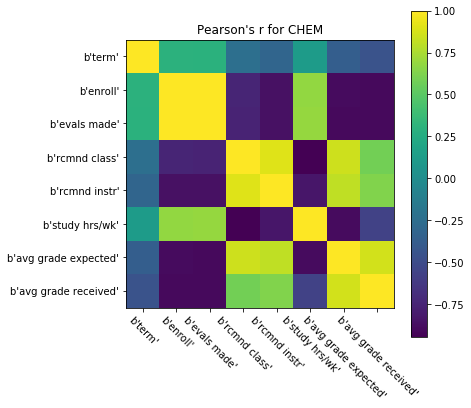

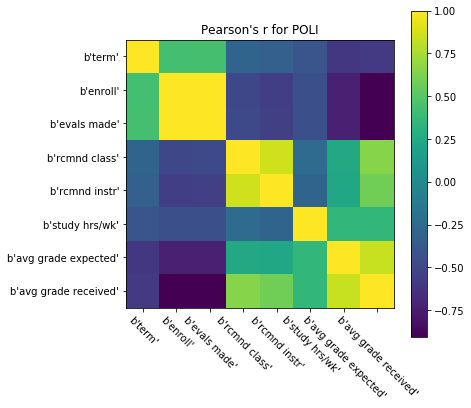

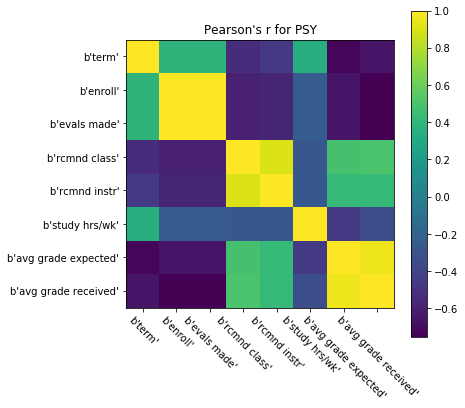

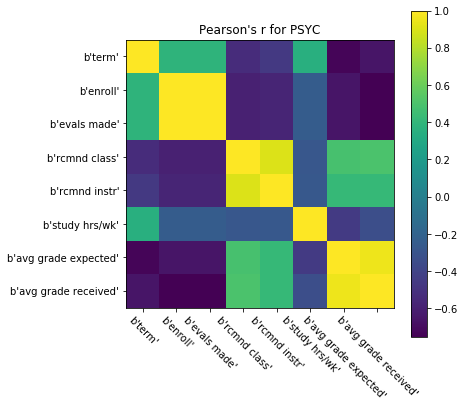

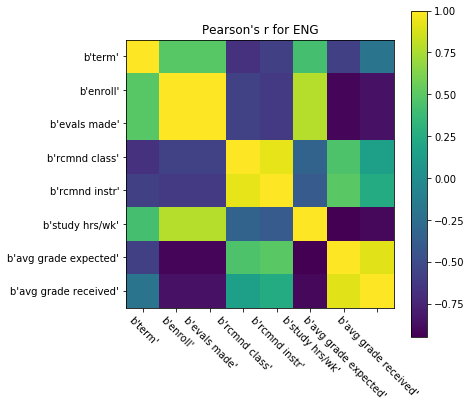

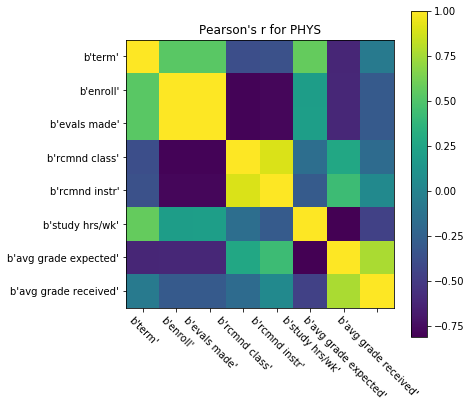

In [9]:
for code, cape in zip(data_files, cape_data):
    # Only use CAPE entries where response rate > 80%
    cape = cape[cape['evals made'] / cape['enroll'] > 0.8].corr()
    
    # Credit for correlation matrix generation to Assignment #3 writeup
    col_labels = [col.encode('utf8') for col in cape.corr().columns]
    plt.figure(figsize=(6,6))
    plt.imshow(cape.corr(),interpolation='none') 
    plt.xticks(range(len(col_labels)), col_labels, rotation=-45)
    plt.yticks(range(len(col_labels)), col_labels)
    plt.colorbar()
    
    plt.title("Pearson's r for {0}".format(code))

### 6c. Are the potential correlations consistent across departments?

The first three most common positive correlations are reassuring and make some sense.  

    A higher class recommendation rating positively corresponds with instructor rating.  
    A higher enrollment count positively corresponds with the number of evaluations made.  
    The expected grade positively corresponds with the actual received grade.  

Of note, however, is the fact that there are more departments with a positive correlation between 'avg grade expected' and 'rcmnd class' than there are departments with the same correlation for 'avg grade received and rcmnd class'.

In [10]:
import numpy as np

In [11]:
num_correlations = {}

for code, cape in zip(data_files, cape_data):
    # Only use CAPE entries where response rate > 80%
    cape = cape[cape['evals made'] / cape['enroll'] > 0.8].corr()

    # Select entries where correlation score is greater than 0.5
    indices = np.where(np.abs(cape) > 0.3)
    indices = [ cape.index[x] + "," + cape.columns[y] for x, y in zip(*indices)
                                        if x != y and x < y]
    
    for coords in indices:
        if num_correlations.get(coords):
            num_correlations[coords] += 1
        else:
            num_correlations[coords] = 1

print("Number of department subjects with correlation score >= 0.5")
correlations = [pair.split(',') + [value] for pair, value in num_correlations.items()]
pd.DataFrame(correlations, columns=['x', 'y', 'departments']). \
    sort_values(by='departments', ascending=False).reset_index(drop=True)

Number of department subjects with correlation score >= 0.5


,x,y,departments
0,enroll,evals made,10
1,rcmnd class,rcmnd instr,10
2,avg grade expected,avg grade received,10
3,study hrs/wk,avg grade expected,6
4,term,enroll,5
5,term,evals made,5
6,rcmnd instr,avg grade expected,4
7,evals made,avg grade expected,4
8,rcmnd class,avg grade received,3
9,rcmnd class,avg grade expected,3


In [12]:
num_correlations = {}

for code, cape in zip(data_files, cape_data):
    # Only use CAPE entries where response rate > 80%
    cape = cape[cape['evals made'] / cape['enroll'] > 0.8].corr()

    # Select entries where correlation score is greater than 0.5
    indices = np.where(cape <= -0.5)
    indices = [ cape.index[x] + "," + cape.columns[y] for x, y in zip(*indices)
                                        if x != y and x < y]
    
    for coords in indices:
        if num_correlations.get(coords):
            num_correlations[coords] += 1
        else:
            num_correlations[coords] = 1

print "Number of department subjects with correlation score <= -0.5"
correlations = [pair.split(',') + [value] for pair, value in num_correlations.iteritems()]
pd.DataFrame(correlations, columns=['x', 'y', 'departments']). \
    sort_values(by='departments', ascending=False).reset_index(drop=True)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Number of department subjects with correlation score <= -0.5")? (<ipython-input-12-ba0a79fb3acd>, line 18)

### 6c. Can we find a correlation between grades received over time at the instructor level?

In order to reduce screen clutter, we will only be using the professor from each subject department who has taught the most classes.

In [ ]:
for code, cape in zip(data_files, cape_data):
    professor = cape.instructor.value_counts().index[0]
    prof_data = cape[cape.instructor == professor].plot( \
        kind='scatter', title=professor + " ({0})".format(code), x='term', y='avg grade expected')

### 6d. Can we find a correlation between grades received over time at the department subject level?

In [ ]:
correlations = []

for code, cape in zip(data_files, cape_data):
    term_gpa = cape.groupby('term')['avg grade received'].mean()
    
    df = pd.DataFrame( \
        {'term': term_gpa.index,
         'avg grade received': term_gpa.values}
    )
    df.plot(kind='scatter', title=code, x='term', y='avg grade received')
    
    correlations.append([code, df.term.corr(df['avg grade received'])])

correlations.sort(key=lambda pair: pair[1], reverse=True)
pd.DataFrame(correlations, columns=['department', 'correlation (term / avg grade received)'])